# Decision Tree Implementation
This notebook describes and displays all the code, results and observations of the Decision Tree Implementation from scratch.

*Task 1*

* First it describes the utils.py which has basic functions required for implementing the Decision Tree
* Then it describes base.py which has the basic structure and other important function of the Decision Tree
* Next we have metrics.py which has all the functions to measure and check the predicted results.
* Following it to showcase the usage of Decision Tree on various test cases we have usage.py

*Task 2*
* For task 2 the classification-exp.py file is explained.

*Task 3*
* For task 3 the auto-efficiency.py is explained.

*Task 4*
* For task 4 the experiments.py file is explained.

# Part 1

# Decision Tree Implementation in `base.py`

## Overview

The `Decision Tree` class in `base.py` is designed to build and predict using a decision tree model. It comprises various nodes and utilizes recursive functions for training and prediction.

## Structure

### 1. **Class Definition**

- **DecisionTree**: The class represents the decision tree model, made up of nodes that perform decision-making or provide final predictions.

### 2. **Functions**

#### **`fit` Function**

- **Purpose**: Trains the decision tree using the provided training data (`X` for features and `y` for labels). It also determines and stores the nature of the features and output labels.
- **Process**:
  - **Tree Creation**: Calls the `create_decision_tree` function, which is recursive. This function builds the tree by creating nodes based on the input DataFrame `X` and the target series `y`.
  - **Leaf Node Conditions**: The recursion stops when either the maximum depth is reached or all `y` values are the same.
  - **Utility Functions**:
    - **`opt_split_attribute`**: Finds the best attribute and split for dividing the dataset to maximize information gain.
    - **`split_data`**: Splits the dataset based on the best attribute and split value determined by `opt_split_attribute`.

  - **Decision Criteria**:
    - **Real Input, Real Output**: Calls `get_best_split` to determine the best split using metrics like Mean Squared Error (MSE) and information gain.
    - **Discrete Input, Real Output**: Calls `get_best_split` to find the best feature using MSE and information gain.
    - **Real Input, Discrete Output**: Calls `get_best_val` to find the best split using criteria like entropy or Gini impurity and information gain.
    - **Discrete Input, Discrete Output**: Calls `get_best_val` to find the best feature using entropy or Gini impurity and information gain.

#### **`predict` Function**

- **Purpose**: Predicts the output values (`y_hat`) using test data (`X_test`).
- **Process**:
  - **`predict_result`**: Processes each row of `X_test` to predict the output value. It iterates through rows, calling the `predict_single` function to obtain predictions for each row.
  - **`predict_single`**: Takes the root of the decision tree and a single row of test data as input. It traverses the tree:
    - **Traversal**: Compares the feature values of the row with the threshold values at each decision node.
    - **Leaf Node**: The traversal continues until a leaf node is reached, where the final prediction is made based on the majority class or average value.

#### **`plot` Function**

- **Purpose**: It plots or prints the nodes of decision tree showcasing split feature, threshold, child, leaf value and other info.

## Summary

The `Decision Tree` class handles both training and prediction. It builds the tree using recursive functions to evaluate splits and attributes, and makes predictions by traversing the constructed tree. The class is flexible in handling both regression and classification tasks by utilizing different criteria for decision-making.


In [9]:
from dataclasses import dataclass
from typing import Literal

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tree.utils import *


np.random.seed(42)

class Node:
    def __init__(self, feature=None, threshold=None, value=None):
        self.feature = feature      # Index of the feature to split on
        self.threshold = threshold  # Threshold value to split on
        self.children = [] # List to store children
        self.value = value  # Value if it is a leaf node


def create_Tree(X: pd.DataFrame, y: pd.Series, depth: int, max_depth: int, real_target: bool, real_features, criterion: str):
    # Check if we're at max depth or if the node is pure
    if depth >= max_depth or len(np.unique(y)) == 1:
        # Create a leaf node
        branch = Node()
        # Edge case
        if len(y) == 0:
            leaf_value = None
        else:
            leaf_value = y.mode()[0] if not real_target else y.mean()
        branch.value=leaf_value
        return branch

    # Get the best feature and split point
    features = X.columns
    best_feature, best_split = opt_split_attribute(X, y, features, real_target, real_features, criterion)

    # If no valid split is found, create a leaf node
    if best_feature is None:
        branch = Node()
        if len(y) == 0:
            leaf_value = None
        else:
            leaf_value = y.mode()[0] if not real_target else y.mean()
        branch.value=leaf_value
        return branch

    # Create a decision node
    if best_split != None:
        branch = Node(feature=best_feature, threshold=best_split)
    else:
        branch = Node(feature=best_feature, threshold=X[best_feature].unique())

    # Split the dataset and create child nodes
    splits = split_data(X, y, best_feature, best_split)
    for X_split, y_split in splits:
        child_node = create_Tree(X_split, y_split, depth + 1, max_depth, real_target, real_features, criterion)
        branch.children.append(child_node)

    return branch



def predict_single(root: Node, X_row: pd.Series):
    current_node = root
    
    while current_node.children:
        feature_value = X_row[current_node.feature]
        
        if isinstance(current_node.threshold, (int, float)):
            # Real feature: Compare with the threshold
            if feature_value <= current_node.threshold:
                current_node = current_node.children[0]
            else:
                current_node = current_node.children[1]
        else:
            # Discrete feature: Handle multiple children
            if feature_value in current_node.threshold:
                # Find the corresponding child based on the feature value
                index = list(current_node.threshold).index(feature_value)
                current_node = current_node.children[index]
            else:
                print(f"Warning: Feature value {feature_value} not found in threshold {current_node.threshold}.")
                return -1  # Or another default value
     
    return current_node.value


def predict_result(root: Node, X_test: pd.DataFrame) -> pd.Series:
    predictions = pd.Series(index=X_test.index)  # Ensure the index is aligned with X_test
    for i in X_test.index:
        predictions.loc[i] = predict_single(root, X_test.loc[i, :])
    
    return predictions

def Display_Node(root: Node, depth=0, decision="?(X"):
    indent = "    " * depth  # Indentation based on depth
    
    if root.value is not None:
        print(f" Leaf: Value = {root.value: .3f}")
    elif isinstance(root.threshold, (int, float)):
        # Handle real-valued splits
        print(f" {decision}{root.feature} <= {root.threshold: .3f})")
        # Yes branch (<= threshold)
        print(f"{indent}    Y:", end="")
        Display_Node(root.children[0], depth + 1)
        # No branch (> threshold)
        print(f"{indent}    N:", end="")
        Display_Node(root.children[1], depth + 1)
    else:
        # Handle discrete-valued splits
        print(f" {decision} {root.feature} in {list(root.threshold)})")
        for i, value in enumerate(root.threshold):
            # for all classes in a discrete feature
            branch_decision = f"{value}:"
            print(f"{indent}    {branch_decision}", end="")
            Display_Node(root.children[i], depth + 1)



@dataclass
class DecisionTree:
    max_depth: int # Hyperparameter
    root: Node # It is stored to be used in predict
    predicted: pd.Series # stores the predicted y_hat
    criterion: str # Hyperparameter

    def __init__(self, criterion, max_depth=6):
        self.criterion = criterion
        self.root = None
        self.max_depth = max_depth
    
    def fit(self, X: pd.DataFrame, y: pd.Series) -> None: 
        # Performing one hot encoding on categorical features       
        X_encoded = one_hot_encoding(X)
        # Variable to store the nature of output label
        real_target = check_ifreal(y)
        # List to store the nature of input features
        real_features = []
        for i in range(X_encoded.shape[1]):
            feature_col = X_encoded.iloc[:, i]
            if check_ifreal(feature_col):
                real_features.append(1)
            else:
                real_features.append(0)

        head = create_Tree(X_encoded, y, 0, self.max_depth, real_target, real_features, self.criterion)
        # stores the root node
        self.root = head
            

    def predict(self, X: pd.DataFrame) -> pd.Series:
        X_encoded = one_hot_encoding(X)
        self.predicted = predict_result(self.root, X_encoded)
        return self.predicted


    def plot(self) -> None:
        # Display the tree starting from the root
        Display_Node(self.root)

    def visualise(self, y):
        plt.scatter(y, self.predicted)
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.title("Actual vs Predicted Values")
        plt.show()



# utils.py

This document outlines the functions and utilities used in the decision tree implementation. These functions handle various tasks such as encoding, splitting, choosing best feature, calculating info gain etc.

## Functions

### **`one_hot_encoding`**

- Uses `pd.get_dummies` to perform one-hot encoding on the DataFrame `X` to convert it to suitable format.

### **`check_ifreal`**

- Determines if the output labels are real (continuous) or discrete by checking if the output series `y` is numeric and whether the proportion of unique values is less than 10%.

### **`entropy`**

- Calculates the entropy of a dataset, which measures the impurity or randomness.

### **`mse`**

- Calculates the mean squared error (MSE) for regression tasks.

### **`gini`**

- Computes the Gini impurity for classification tasks.

### **`information_gain`**

- **Purpose**: Calculates the information gain based on different criteria (entropy, Gini index, MSE).
- **Description**: Computes the gain for splitting a dataset `Y` based on attribute `attr` using the specified criterion:
  - `"entropy"`: Used if Y is discrete and criterion(hyperparameter) is info_gain.
  - `"gini_index"`: Used if Y is discrete and criterion is gini_index.
  - `"mse"`: Used if Y is real.

### **`get_best_split`**

- **Purpose**: Finds the best split value for real-valued features.
- **Description**: Determines the optimal split point by evaluating different split values and calculating information gain or MSE.

### **`get_best_val`**

- **Purpose**: Finds the best split value for discrete features.
- **Description**: Determines the optimal feature based on the criterion (entropy, Gini index) and returns the best feature.

### **`opt_split_attribute`**

- **Purpose**: Finds the best attribute to split on for building the decision tree.
- **Description**: Evaluates all features and determines the one that provides the highest information gain or the best split based on the criterion.
Works for all types of feature discrete, real or mix.

### **`split_data`**

- **Purpose**: Splits the dataset into subsets based on the value of a feature.
- **Description**:
  - For discrete features: Splits based on unique values of the attribute.
  - For real-valued features: Splits based on a threshold value.



In [10]:
import pandas as pd
import numpy as np

def one_hot_encoding(X: pd.DataFrame) -> pd.DataFrame:
    return pd.get_dummies(X)

def check_ifreal(y: pd.Series) -> bool:
    if pd.api.types.is_numeric_dtype(y):
        unique=len(y.unique())
        total=y.count()
        if (unique/total)<0.1:  
            return False
        else:
            return True
    else:
        return False


def entropy(Y: pd.Series) -> float:
    n=Y.size
    classes=Y.unique()
    H=0
    for i in range(len(classes)):
        m=0
        for j in range(len(Y)):
            if Y.iloc[j]==classes[i]:
                m+=1
        p=m/n
        H+=p*np.log2(p)
    return -1*H


def mse(Y: pd.Series) -> float:
    avg=Y.mean()
    sq_err=(Y-avg)**2
    mean_sq_err=sq_err.mean()
    return mean_sq_err


def gini(y: pd.Series) -> float:
        classes = y.value_counts(normalize=True)
        return 1 - np.sum(classes ** 2)


def information_gain(Y: pd.Series, attr: pd.Series, criterion: str) -> float:
    Gain=0
    if (criterion=="entropy"):
        HS=entropy(Y)
        Gain+=HS
        c = attr.unique()
        for i in range(len(c)):
            Si=[]
            for j in range(len(attr)):
                if attr.iloc[j] == c[i]:
                    Si.append(Y.iloc[j])
            Gain-=(len(Si)/len(Y))*entropy(pd.Series(Si))

        return Gain
    
    elif criterion == "gini_index":
        HS = gini(Y)
        Gain = HS
        c = attr.unique()
        for i in range(len(c)):
            Si=[]
            for j in range(len(attr)):
                if attr.iloc[j] == c[i]:
                    Si.append(Y.iloc[j])
            Gain-=(len(Si)/len(Y))*gini(pd.Series(Si))

        return Gain

    elif criterion == "mse":
        HS = mse(Y)
        Gain = HS
        c = attr.unique()
        for i in range(len(c)):
            Si = Y[attr == c[i]]
            Gain -= (len(Si) / len(Y)) * mse(Si)
            
        return Gain

# This function is called when the output label is real.
def get_best_split(X: pd.Series, y: pd.Series,  real, criterion: str='information_gain') -> float:
    best_split_value = None
    best_score = -float('inf') 

    # INput feature is real
    if (real):
        # Sort the indices based on value of X
        sorted_indices = np.argsort(X)
        sorted_X = X.iloc[sorted_indices]
        sorted_y = y.iloc[sorted_indices]
        
        for i in range(1, len(sorted_X)):
            # checks various possible splits
            split_value = (sorted_X.iloc[i-1] + sorted_X.iloc[i]) / 2
            # segregating the series based on split values
            left = sorted_X <= split_value
            if (criterion=='information_gain'):
                info_gain = information_gain(y, left, 'mse')
            else:
                info_gain = information_gain(y, left, 'mse')
            # storing the best info gain
            if info_gain > best_score:
                best_score = info_gain
                best_split_value = split_value

    # INput feature is discrete
    else:
        if (criterion=='information_gain'):
            best_score = information_gain(y, X, 'mse')
        else:
            best_score = information_gain(y, X, 'mse')
        
    return best_split_value, best_score


# This function is called when the output label is discrete
def get_best_val(X: pd.Series, y: pd.Series, real, criterion: str='information_gain') -> str:
    best_val = None
    best_info_gain = -float('inf')
    
    # Discrete feature 
    if (real==0):
        if (criterion=='information_gain'):
            best_info_gain=information_gain(y, X, 'entropy')
        else:
            best_info_gain=information_gain(y, X, 'gini_index')
    
    # Real feature
    else:
        # Sort the indices based on value of X
        sorted_indices = np.argsort(X)
        sorted_X = X.iloc[sorted_indices]
        sorted_y = y.iloc[sorted_indices]
        
        for i in range(1, len(sorted_X)):
            # checks various possible splits
            split_value = (sorted_X.iloc[i-1] + sorted_X.iloc[i]) / 2
            # segregating the series based on split values
            left = sorted_X <= split_value
            if (criterion=='information_gain'):
                info_gain = information_gain(y, left, 'entropy')
            else:
                info_gain = information_gain(y, left, 'gini_index')
            # storing the best info gain
            if info_gain > best_info_gain:
                best_info_gain = info_gain
                best_val = split_value
            
    return best_val, best_info_gain


def opt_split_attribute(X: pd.DataFrame, y: pd.Series, features: pd.Series, real_target: bool, real_feature, criterion: str):
    # According to whether the features are real or discrete valued and the criterion, find the attribute from the features series with the maximum information gain (entropy or variance based on the type of output) or minimum gini index (discrete output).
    best_feature=None
    best_split=None
    best_info_gain=-float('inf')
    if real_target:
        c = 0
        for i in features:
            split, info_gain = get_best_split(X.loc[:,i], y, real_feature[c], criterion)
            c += 1
            # Gets the best info gain and split among various features 
            if info_gain>best_info_gain:
                best_info_gain=info_gain
                best_split=split
                best_feature=i
    else:
        c = 0
        for i in features:
            split, info_gain = get_best_val(X.loc[:,i], y, real_feature[c], criterion)
            c += 1
            # Gets the best info gain and split among various features 
            if info_gain>best_info_gain:
                best_info_gain=info_gain
                best_split=split
                best_feature=i
    return best_feature, best_split


def split_data(X: pd.DataFrame, y: pd.Series, attribute, value):

    if value is None:
        # For discrete features
        splits = []
        unique_values = X[attribute].unique()
        
        for u in unique_values:
            X_split = X[X[attribute] == u]
            y_split = y[X[attribute] == u]
            splits.append((X_split, y_split))
    else:
        # For real-valued features
        X_split_left = X[X[attribute] <= value]
        y_split_left = y[X[attribute] <= value]
        
        X_split_right = X[X[attribute] > value]
        y_split_right = y[X[attribute] > value]
        
        splits = [(X_split_left, y_split_left), (X_split_right, y_split_right)]
        
    return splits



# metrics.py

It has all the function required for assessing and comparing the performance of the decision tree model. 
* Accuracy
* Precision
* Recall
* rmse
* mae

In [11]:
from typing import Union
import pandas as pd
import numpy as np

def accuracy(y_hat: pd.Series, y: pd.Series) -> float:
    """
    Function to calculate the accuracy
    """

    """
    The following assert checks if sizes of y_hat and y are equal.
    Students are required to add appropriate assert checks at places to
    ensure that the function does not fail in corner cases.
    """
    assert y_hat.size == y.size
    correct_pred = (y_hat == y).sum()
    accuracy = correct_pred/y.size
    return accuracy


def precision(y_hat: pd.Series, y: pd.Series, cls: Union[int, str]) -> float:
    """
    Function to calculate the precision
    """
    true_positive = ((y_hat == cls) & (y == cls)).sum()
    predicted_positive = (y_hat == cls).sum()
    if predicted_positive == 0:
        return 0.0
    
    precision = true_positive / predicted_positive
    return precision


def recall(y_hat: pd.Series, y: pd.Series, cls: Union[int, str]) -> float:
    """
    Function to calculate the recall
    """
    true_positive = ((y_hat == cls) & (y == cls)).sum()
    actual_positive = (y == cls).sum()
    if actual_positive == 0:
        return 0.0
    
    recall = true_positive / actual_positive
    return recall


def rmse(y_hat: pd.Series, y: pd.Series) -> float:
    """
    Function to calculate the root-mean-squared-error(rmse)
    """
    assert y_hat.size == y.size
    residuals = y_hat - y
    mse = (residuals ** 2).mean()
    rmse = np.sqrt(mse)
    return rmse
    


def mae(y_hat: pd.Series, y: pd.Series) -> float:
    """
    Function to calculate the mean-absolute-error(mae)
    """
    assert y_hat.size == y.size
    residuals = y_hat - y
    mae = residuals.abs().mean()
    return mae

# usage.py

The following code cells showcases the usage of the self implemented decision tree model on various combinations or real and discrete input and output.

The tree is fitted and predictions are made on 
* Real Input, Real Output
* Discrete Input, Real Output
* Real Input, Discrete Output
* Discrete Input, Real Output

It plots the decision tree and prints metrics like rmse, mae, accuracy, precision, recall etc.

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tree.base import *
from metrics import *

np.random.seed(42)

In [13]:
# Test case 1
# Real Input and Real Output

N = 30
P = 5
X = pd.DataFrame(np.random.randn(N, P))
y = pd.Series(np.random.randn(N))

for criteria in ["information_gain", "gini_index"]:
    tree = DecisionTree(criterion=criteria)  # Split based on Inf. Gain
    tree.fit(X, y)
    y_hat = tree.predict(X)
    print("Criteria :", criteria)
    print("RMSE: ", rmse(y_hat, y))
    print("MAE: ", mae(y_hat, y))
    tree.plot()


Criteria : information_gain
RMSE:  0.30926365884663126
MAE:  0.19619454429754504
 ?(X1 <= -1.194)
    Y: Leaf: Value =  2.720
    N: ?(X4 <=  0.387)
        Y: ?(X0 <=  1.508)
            Y: ?(X4 <= -1.744)
                Y: ?(X1 <=  0.813)
                    Y: ?(X0 <=  0.051)
                        Y: Leaf: Value =  0.657
                        N: Leaf: Value =  0.413
                    N: Leaf: Value =  0.963
                N: ?(X2 <=  1.241)
                    Y: ?(X3 <= -0.855)
                        Y: Leaf: Value =  0.080
                        N: Leaf: Value = -0.501
                    N: Leaf: Value =  0.822
            N: ?(X0 <=  1.870)
                Y: Leaf: Value =  1.454
                N: Leaf: Value =  0.827
        N: ?(X0 <= -0.357)
            Y: ?(X0 <= -0.490)
                Y: ?(X0 <= -0.552)
                    Y: Leaf: Value =  1.866
                    N: Leaf: Value =  1.897
                N: Leaf: Value =  1.159
            N: ?(X4 <=  1.003)
  

In [14]:
# Test case 2
# Real Input and Discrete Output

N = 30
P = 5
X = pd.DataFrame(np.random.randn(N, P))
y = pd.Series(np.random.randint(P, size=N), dtype="category")

for criteria in ["information_gain", "gini_index"]:
    tree = DecisionTree(criterion=criteria)  # Split based on Inf. Gain
    tree.fit(X, y)
    y_hat = tree.predict(X)
    tree.plot()
    print("Criteria :", criteria)
    print("Accuracy: ", accuracy(y_hat, y))
    for cls in y.unique():
        print("Precision: ", precision(y_hat, y, cls))
        print("Recall: ", recall(y_hat, y, cls))


 ?(X0 <=  0.674)
    Y: ?(X0 <=  0.372)
        Y: ?(X0 <= -0.094)
            Y: ?(X0 <= -0.761)
                Y: ?(X0 <= -1.076)
                    Y: ?(X0 <= -1.606)
                        Y: Leaf: Value =  1.000
                        N: Leaf: Value =  4.000
                    N: ?(X0 <= -0.932)
                        Y: Leaf: Value =  4.000
                        N: Leaf: Value =  0.000
                N: ?(X0 <= -0.213)
                    Y: ?(X0 <= -0.276)
                        Y: Leaf: Value =  1.000
                        N: Leaf: Value =  4.000
                    N: Leaf: Value =  2.000
            N: ?(X0 <=  0.105)
                Y: ?(X0 <=  0.059)
                    Y: Leaf: Value =  4.000
                    N: Leaf: Value =  2.000
                N: ?(X0 <=  0.115)
                    Y: Leaf: Value =  0.000
                    N: ?(X0 <=  0.238)
                        Y: Leaf: Value =  4.000
                        N: Leaf: Value =  1.000
        N: ?(X0

In [15]:
# Test case 3
# Discrete Input and Discrete Output

N = 30
P = 5
X = pd.DataFrame({i: pd.Series(np.random.randint(P, size=N), dtype="category") for i in range(5)})
y = pd.Series(np.random.randint(P, size=N), dtype="category")

for criteria in ["information_gain", "gini_index"]:
    tree = DecisionTree(criterion=criteria)  # Split based on Inf. Gain
    tree.fit(X, y)
    y_hat = tree.predict(X)
    tree.plot()
    print("Criteria :", criteria)
    print("Accuracy: ", accuracy(y_hat, y))
    for cls in y.unique():
        print("Precision: ", precision(y_hat, y, cls))
        print("Recall: ", recall(y_hat, y, cls))


 ?(X 1_0 in [False, True])
    False: ?(X 1_4 in [False, True])
        False: ?(X 4_3 in [False, True])
            False: ?(X 3_2 in [False, True])
                False: ?(X 3_0 in [True, False])
                    True: Leaf: Value =  0.000
                    False: ?(X 2_2 in [False, True])
                        False: Leaf: Value =  2.000
                        True: Leaf: Value =  0.000
                True: ?(X 0_4 in [False, True])
                    False: Leaf: Value =  3.000
                    True: Leaf: Value =  0.000
            True: ?(X 0_1 in [True, False])
                True: Leaf: Value =  3.000
                False: Leaf: Value =  1.000
        True: ?(X 2_3 in [True, False])
            True: Leaf: Value =  1.000
            False: ?(X 0_4 in [False, True])
                False: Leaf: Value =  3.000
                True: Leaf: Value =  1.000
    True: ?(X 4_1 in [False, True])
        False: ?(X 0_2 in [False, True])
            False: ?(X 0_3 in [True,

In [16]:
# Test case 4
# Discrete Input and Real Output

N = 30
P = 5
X = pd.DataFrame({i: pd.Series(np.random.randint(P, size=N), dtype="category") for i in range(5)})
y = pd.Series(np.random.randn(N))

for criteria in ["information_gain", "gini_index"]:
    tree = DecisionTree(criterion=criteria)  # Split based on Inf. Gain
    tree.fit(X, y)
    y_hat = tree.predict(X)
    tree.plot()
    print("Criteria :", criteria)
    print("RMSE: ", rmse(y_hat, y))
    print("MAE: ", mae(y_hat, y))
    

 ?(X 2_1 in [False, True])
    False: ?(X 1_4 in [True, False])
        True: ?(X 2_2 in [True, False])
            True: ?(X 0_2 in [False, True])
                False: ?(X 0_1 in [False, True])
                    False: Leaf: Value =  1.006
                    True: Leaf: Value =  0.836
                True: Leaf: Value = -0.203
            False: Leaf: Value =  2.075
        False: ?(X 3_0 in [True, False])
            True: ?(X 2_2 in [True, False])
                True: Leaf: Value = -0.577
                False: ?(X 1_1 in [True, False])
                    True: Leaf: Value =  1.442
                    False: ?(X 0_0 in [True, False])
                        True: Leaf: Value =  1.168
                        False: Leaf: Value =  0.324
            False: ?(X 0_4 in [True, False])
                True: ?(X 3_1 in [False, True])
                    False: ?(X 2_0 in [False, True])
                        False: Leaf: Value = -1.069
                        True: Leaf: Value = -0.

# Part 3

## Comparison between Self-implemented and Scikit learn decision tree

This code compares the performance of a self implementation of a decision tree regressor with the decision tree regressor provided by the `scikit-learn` library. The comparison is done on the `auto-mpg` dataset, which contains data on various features of cars and their corresponding miles per gallon (MPG) values.

### Steps Involved:
1. **Data Loading and Cleaning:**
   - The `auto-mpg` dataset is loaded from the UCI Machine Learning Repository.
   - The 'car name' column is removed as it is not relevant for regression.
   - The 'horsepower' column, which contains some missing values (marked as '?'), is cleaned by replacing them with `0` and converting the column to numeric type.

2. **Feature and Target Separation:**
   - The target variable `y` is the 'mpg' column.
   - The remaining columns are used as features `X`.

3. **Data Splitting:**
   - The dataset is split into training and testing sets using an 80-20 split.

4. **Model Training and Evaluation:**
   - **Scikit-learn Decision Tree Regressor:**
     - A decision tree regressor is trained using `scikit-learn`.
     - The model's performance is evaluated using R² (coefficient of determination) and Mean Absolute Error (MAE) on the test set.
   
   - **Self Implemented Decision Tree Regressor:**
     - A self implemented decision tree is used to train the model with the same dataset.
     - The model's performance is also evaluated using RMSE and MAE on the test set.

### Results:
- **Scikit-learn Decision Tree:**
  - RMSE: 3.142
  - MAE: 2.2330 
  
- **Self Decision Tree:**
  - RMSE: 3.6198
  - MAE: 2.4517
  
Thus the performance of self implemented Decision Tree is quite good and is comparable to the scikit learn's decision tree implementation.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from tree.base import DecisionTree
from metrics import *

np.random.seed(42)

# Reading the data
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
data = pd.read_csv(url, delim_whitespace=True, header=None,
                 names=["mpg", "cylinders", "displacement", "horsepower", "weight",
                        "acceleration", "model year", "origin", "car name"])

# Clean the above data by removing redundant columns and rows with junk value
data.drop('car name', axis=1, inplace=True)

data['horsepower'].replace('?', 0, inplace=True)
data['horsepower'] = pd.to_numeric(data['horsepower'])

y = data['mpg']
X = data.drop('mpg', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Compare the performance of your model with the decision tree module from scikit learn
sklearn_tree = DecisionTreeRegressor(max_depth=5, random_state=21)
sklearn_tree.fit(X_train, y_train)
y_pred_sklearn = sklearn_tree.predict(X_test)
rms = np.sqrt(mean_squared_error(y_test, y_pred_sklearn))
sklearn_mae = mean_absolute_error(y_test, y_pred_sklearn)
print("Root Mean Square Error (RMSE):", rms)
print("Mean Absolute Error (MAE): {:.4f}".format(sklearn_mae))



model = DecisionTree(criterion="gini_index", max_depth=5)
model.fit(X_train, y_train)
y_hat = model.predict(X_test)

score = rmse(y_hat, y_test)
score2 = mae(y_hat, y_test)
print("Self implemented Decision Tree R^2: {:.4f}".format(score))
print("Mean Absolute Error (MAE): {:.4f}".format(score2))

Root Mean Square Error (RMSE): 3.142015077843818
Mean Absolute Error (MAE): 2.2330
Self implemented Decision Tree R^2: 3.6198
Mean Absolute Error (MAE): 2.4517


# Part 2
# classification.py

In this project, we implemented both k-fold and nested cross-validation techniques to evaluate and tune a decision tree model. These techniques involve strategically splitting the data into various parts for training, validation, and testing to ensure the model's performance is accurately assessed.

## k-Fold Cross-Validation

### What is k-Fold Cross-Validation?

k-Fold Cross-Validation is a method where the dataset is divided into `k` equal parts (or folds). In each iteration of cross-validation, one of these parts is used as the test set, while the remaining `k-1` parts are combined and used for training the model. This process is repeated `k` times, with each part being used as the test set exactly once.

### How We Divided the Data

1. **Initial Split:**
   - The training data (`X_train` and `y_train`) was split into `k` folds. 
   - Each fold contained an equal number of samples.

2. **Iteration Process:**
   - For each fold `i`:
     - The `i-th` fold was used as the test set (`test_set`).
     - The remaining `k-1` folds were combined to form the training set (`training_set`).

## Nested Cross-Validation

Nested Cross-Validation adds an additional layer of cross-validation within each training set during the outer k-fold cross-validation. This is particularly useful for hyperparameter tuning, ensuring that the model's performance is not overestimated due to overfitting.

### How We Divided the Data

1. **Outer Loop:**
   - Similar to k-fold cross-validation, we divided the data into `k` folds.
   - In each iteration of the outer loop, one fold was used as the test set, and the remaining `k-1` folds were used for further training and validation.

2. **Inner Loop (Validation Split):**
   - The training set obtained from the outer loop was further divided into `k` folds.
   - In each iteration of the inner loop:
     - One fold was used as the validation set (`val_set`) for hyperparameter tuning.
     - The remaining folds were used as the actual training set (`training_X`).

Then, the set of hyperparameters giving highest accuracies in the inner loop are selected and tested on the outer loops validation set and the accuracy of each fold is shown. 
Finally each of these five models are trained on the X_train and tested on X_test.

## Conclusion

By strategically splitting the data into training, validation, and test sets using k-fold and nested cross-validation, we ensured that our model's performance metrics are reliable. This approach also allowed us to fine-tune the model's hyperparameters, minimizing the risk of overfitting and ensuring the model's generalization to new data.


200
 ?(X0 <=  1.062)
    Y: ?(X0 <=  0.852)
        Y: ?(X0 <= -1.030)
            Y: Leaf: Value =  0.000
            N: ?(X0 <= -0.998)
                Y: Leaf: Value =  0.000
                N: ?(X0 <=  0.617)
                    Y: ?(X0 <= -0.946)
                        Y: ?(X0 <= -0.965)
                            Y: Leaf: Value =  0.000
                            N: Leaf: Value =  1.000
                        N: ?(X0 <= -0.851)
                            Y: Leaf: Value =  0.000
                            N: ?(X0 <= -0.805)
                                Y: Leaf: Value =  0.000
                                N: ?(X0 <=  0.555)
                                    Y: ?(X0 <= -0.426)
                                        Y: Leaf: Value =  0.000
                                        N: ?(X0 <=  0.465)
                                            Y: ?(X0 <=  0.385)
                                                Y: ?(X0 <=  0.179)
                                            

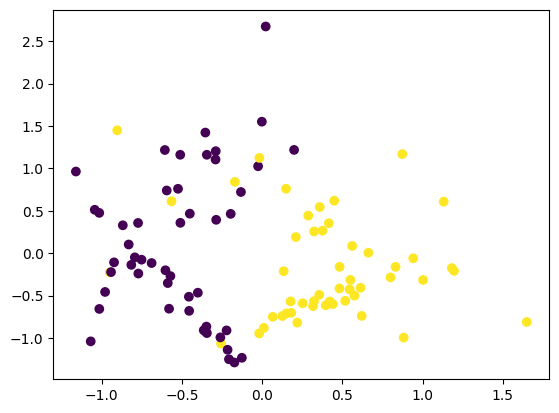

In [50]:
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
from tree.base import *
from metrics import *
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

np.random.seed(2)

# Code given in the question
X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=2, class_sep=0.5)

# For plotting
plt.scatter(X[:, 0], X[:, 1], c=y)

X = pd.DataFrame(X)
y = pd.Series(y)
print(X.size)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

# Write the code for Q2 a) and b) below. Show your results.
for criteria in ["information_gain", "gini_index"]:
    tree = DecisionTree(criterion=criteria, max_depth=15)
    tree.fit(X_train, y_train)
    y_hat = tree.predict(X_test)
    tree.plot()
    print("Criteria :", criteria)
    print("Accuracy: ", accuracy(y_hat, y_test))
    for cls in y_test.unique():
        print("Precision: ", precision(y_hat, y, cls))
        print("Recall: ", recall(y_hat, y, cls))


In [49]:
# Define the number of folds (k)
k = 5

predictions = {}
accuracies = []
super_hypers = []
fold_size = len(X_train) // k

for i in range(k):
    # Split the data into training and test sets
    test_start = i * fold_size
    test_end = (i + 1) * fold_size
    test_set = pd.DataFrame(X_train[test_start:test_end])
    test_labels = pd.Series(y_train[test_start:test_end])
    
    training_set = pd.DataFrame(np.concatenate((X_train[:test_start], X_train[test_end:]), axis=0))
    training_labels = pd.Series(np.concatenate((y_train[:test_start], y_train[test_end:]), axis=0))

    
    best_hypers = []
    inner_fold = len(training_set) // k
    for j in range(k):
        val_beg = j * inner_fold
        val_fin = (j+1) * inner_fold
        val_X = pd.DataFrame(training_set[val_beg:val_fin])
        val_y = pd.Series(training_labels[val_beg:val_fin])
        training_X = pd.DataFrame(np.concatenate((training_set[:val_beg], training_set[val_fin:]), axis=0))
        training_y = pd.Series(np.concatenate((training_labels[:val_beg], training_labels[val_fin:]), axis=0))

        hyperparameters = {}
        hyperparameters['max_depth'] = [4,6,8,10,12,14,16]
        hyperparameters['criterion'] = ['information_gain', 'gini_index']

        max_score = 0
        best_depth = 3
        best_criterion = "information_gain"
        for d in hyperparameters['max_depth']:
            for c in hyperparameters['criterion']:
                model = DecisionTree(criterion=c, max_depth=d)
                model.fit(training_X, training_y)
                y_hat = model.predict(val_X)
                score = accuracy(y_hat, val_y)
                if (score>max_score):
                    best_depth = d
                    best_criterion = c
                    max_score = score
        
        best_hypers.append([best_depth, best_criterion])
    
    super_depth = 0
    super_criterion = "information_gain"
    max_accuracy = 0
    for l in range(len(best_hypers)):
        model = DecisionTree(criterion=best_hypers[l][1], max_depth=best_hypers[l][0])
        model.fit(training_set, training_labels)
        y_pred = model.predict(test_set)
        acc = accuracy(y_pred, test_labels)
        if (acc>max_accuracy):
            max_accuracy = acc
            super_depth = best_hypers[l][0]
            super_criterion = best_hypers[l][1]
    
    super_hypers.append([super_depth, super_criterion])
    accuracies.append(max_accuracy)
                
                

# Print the predictions and accuracies of each fold
for i in range(k):
    print("Fold {}: Accuracy: {:.4f}".format(i+1, accuracies[i]))
    super_model = DecisionTree(criterion=super_hypers[i][1], max_depth=super_hypers[i][0])
    super_model.fit(X_train, y_train)
    Y_hat = super_model.predict(X_test)
    Acc = accuracy(Y_hat, y_test)
    print("Model {}: Accuracy on test: {:.4f}".format(i+1, Acc))

Fold 1: Accuracy: 0.9286
Model 1: Accuracy on test: 0.7000
Fold 2: Accuracy: 0.7857
Model 2: Accuracy on test: 0.7000
Fold 3: Accuracy: 0.7143
Model 3: Accuracy on test: 0.8333
Fold 4: Accuracy: 1.0000
Model 4: Accuracy on test: 0.7000
Fold 5: Accuracy: 0.8571
Model 5: Accuracy on test: 0.4667


# Part 4
## Time Complexity Analysis

This task focuses on analyzing the time complexity of a custom Decision Tree implementation. The analysis involves evaluating how different characteristics of synthetic datasets, such as the number of samples, feature types (discrete vs. continuous), and output types (discrete vs. real), impact the time taken for training and prediction.

## Table of Contents

1. [Data Generation](#data-generation)
2. [Running the Experiments](#running-the-experiments)
3. [Storing and Plotting Results](#storing-and-plotting-results)
4. [Requirements](#requirements)
5. [Usage](#usage)

## Data Generation

The `generate_data` function is used to create synthetic datasets for the experiments. It generates data based on the following parameters:
- **Number of Samples (N)**: Defines how many samples will be included in the dataset.
- **Number of Features (M)**: Defines how many features each sample will have.
- **Feature Type (Discrete or Continuous)**: Determines whether the features are discrete (binary) or continuous (floating-point numbers).
- **Output Type (Discrete or Real)**: Determines whether the output values are discrete (binary) or real-valued (floating-point numbers).

The function returns:
- A DataFrame for the features.
- A Series for the target values.

## Running the Experiments

The `run_experiment` function measures the average time taken by the Decision Tree model to perform training (`fit` method) and prediction (`predict` method). It executes multiple runs to compute the average times, considering:
- **Feature Type**: Whether the features are discrete or continuous.
- **Output Type**: Whether the output values are discrete or real-valued.
- **Number of Samples (N)**: The size of the dataset.
- **Number of Features (M)**: The number of features in the dataset.


## Theoretical Time Complexity

For a decision tree algorithm, the theoretical time complexity for training (fitting) is 
O(N⋅M⋅2^d), where:

- **N** is the number of samples.
- **M** is the number of features.
- **d** is the depth of the tree.

This complexity arises because the algorithm evaluates each feature at each node for all samples. As the tree depth increases, the number of nodes doubles, leading to the 2^d factor.

For prediction, the time complexity is O(M⋅d), as each sample follows a single path from the root to a leaf node, which involves d comparisons, each with M features.

In [4]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from tree.base import DecisionTree
from metrics import *

np.random.seed(42)
num_average_time = 10 # Number of times to run each experiment to calculate the average values


# Function to create fake data (take inspiration from usage.py)
def generate_data(N, M, discrete=True, real_output=False):
    if discrete:
        X = np.random.randint(0, N//M+2, size=(N, M))
    else:
        X = np.random.rand(N, M)
    
    if real_output:
        y = np.random.rand(N)
    else:
        y = np.random.randint(0, N//M, size=N)
    
    return pd.DataFrame(X), pd.Series(y)

# Function to calculate average time (and std) taken by fit() and predict() for different N and P for 4 different cases of DTs
def run_experiment(N, M, discrete_input, real_output, num_average_time=10):
    learning_times = []
    prediction_times = []
    X, y = generate_data(N, M, discrete_input, real_output)
    
    for _ in range(num_average_time):
        if real_output:
            model = DecisionTree(criterion='information_gain')
        else:
            model = DecisionTree(criterion='information_gain')
        
        start_time = time.time()
        model.fit(X, y)
        learning_times.append(time.time() - start_time)
        
        start_time = time.time()
        model.predict(X)
        prediction_times.append(time.time() - start_time)
    
    learning_time_avg = np.mean(learning_times)
    learning_time_var = np.var(learning_times)

    prediction_time_avg = np.mean(prediction_times)
    prediction_time_var = np.var(prediction_times)
    
    return learning_time_avg, prediction_time_avg



# Run the functions, Learn the DTs and Show the results/plots
N_values = [10, 20, 30, 50]
M_values = [5, 10]

results = []

for N in range(len(N_values)):
    for M in range(len(M_values)):
        for i in [True, False]:
            for o in [True, False]:
                learning_time_avg, prediction_time_avg = run_experiment(N_values[N], M_values[M], i, o, num_average_time)
                results.append((N_values[N], M_values[M], i, o, learning_time_avg, prediction_time_avg))

results_df = pd.DataFrame(results, columns=['N', 'M', 'Discrete Input', 'Real Output', 'Learning Time Avg', 'Prediction Time Avg'])
results_df


,N,M,Discrete Input,Real Output,Learning Time Avg,Prediction Time Avg
0,10,5,True,True,0.654328,0.005737
1,10,5,True,False,0.277919,0.007170
2,10,5,False,True,0.468724,0.001302
3,10,5,False,False,0.135314,0.001697
4,10,10,True,True,0.580652,0.000204
5,10,10,True,False,0.000000,0.006250
6,10,10,False,True,0.529370,0.004275
7,10,10,False,False,0.000131,0.003228
8,20,5,True,True,0.696561,0.002513
9,20,5,True,False,0.653410,0.002317


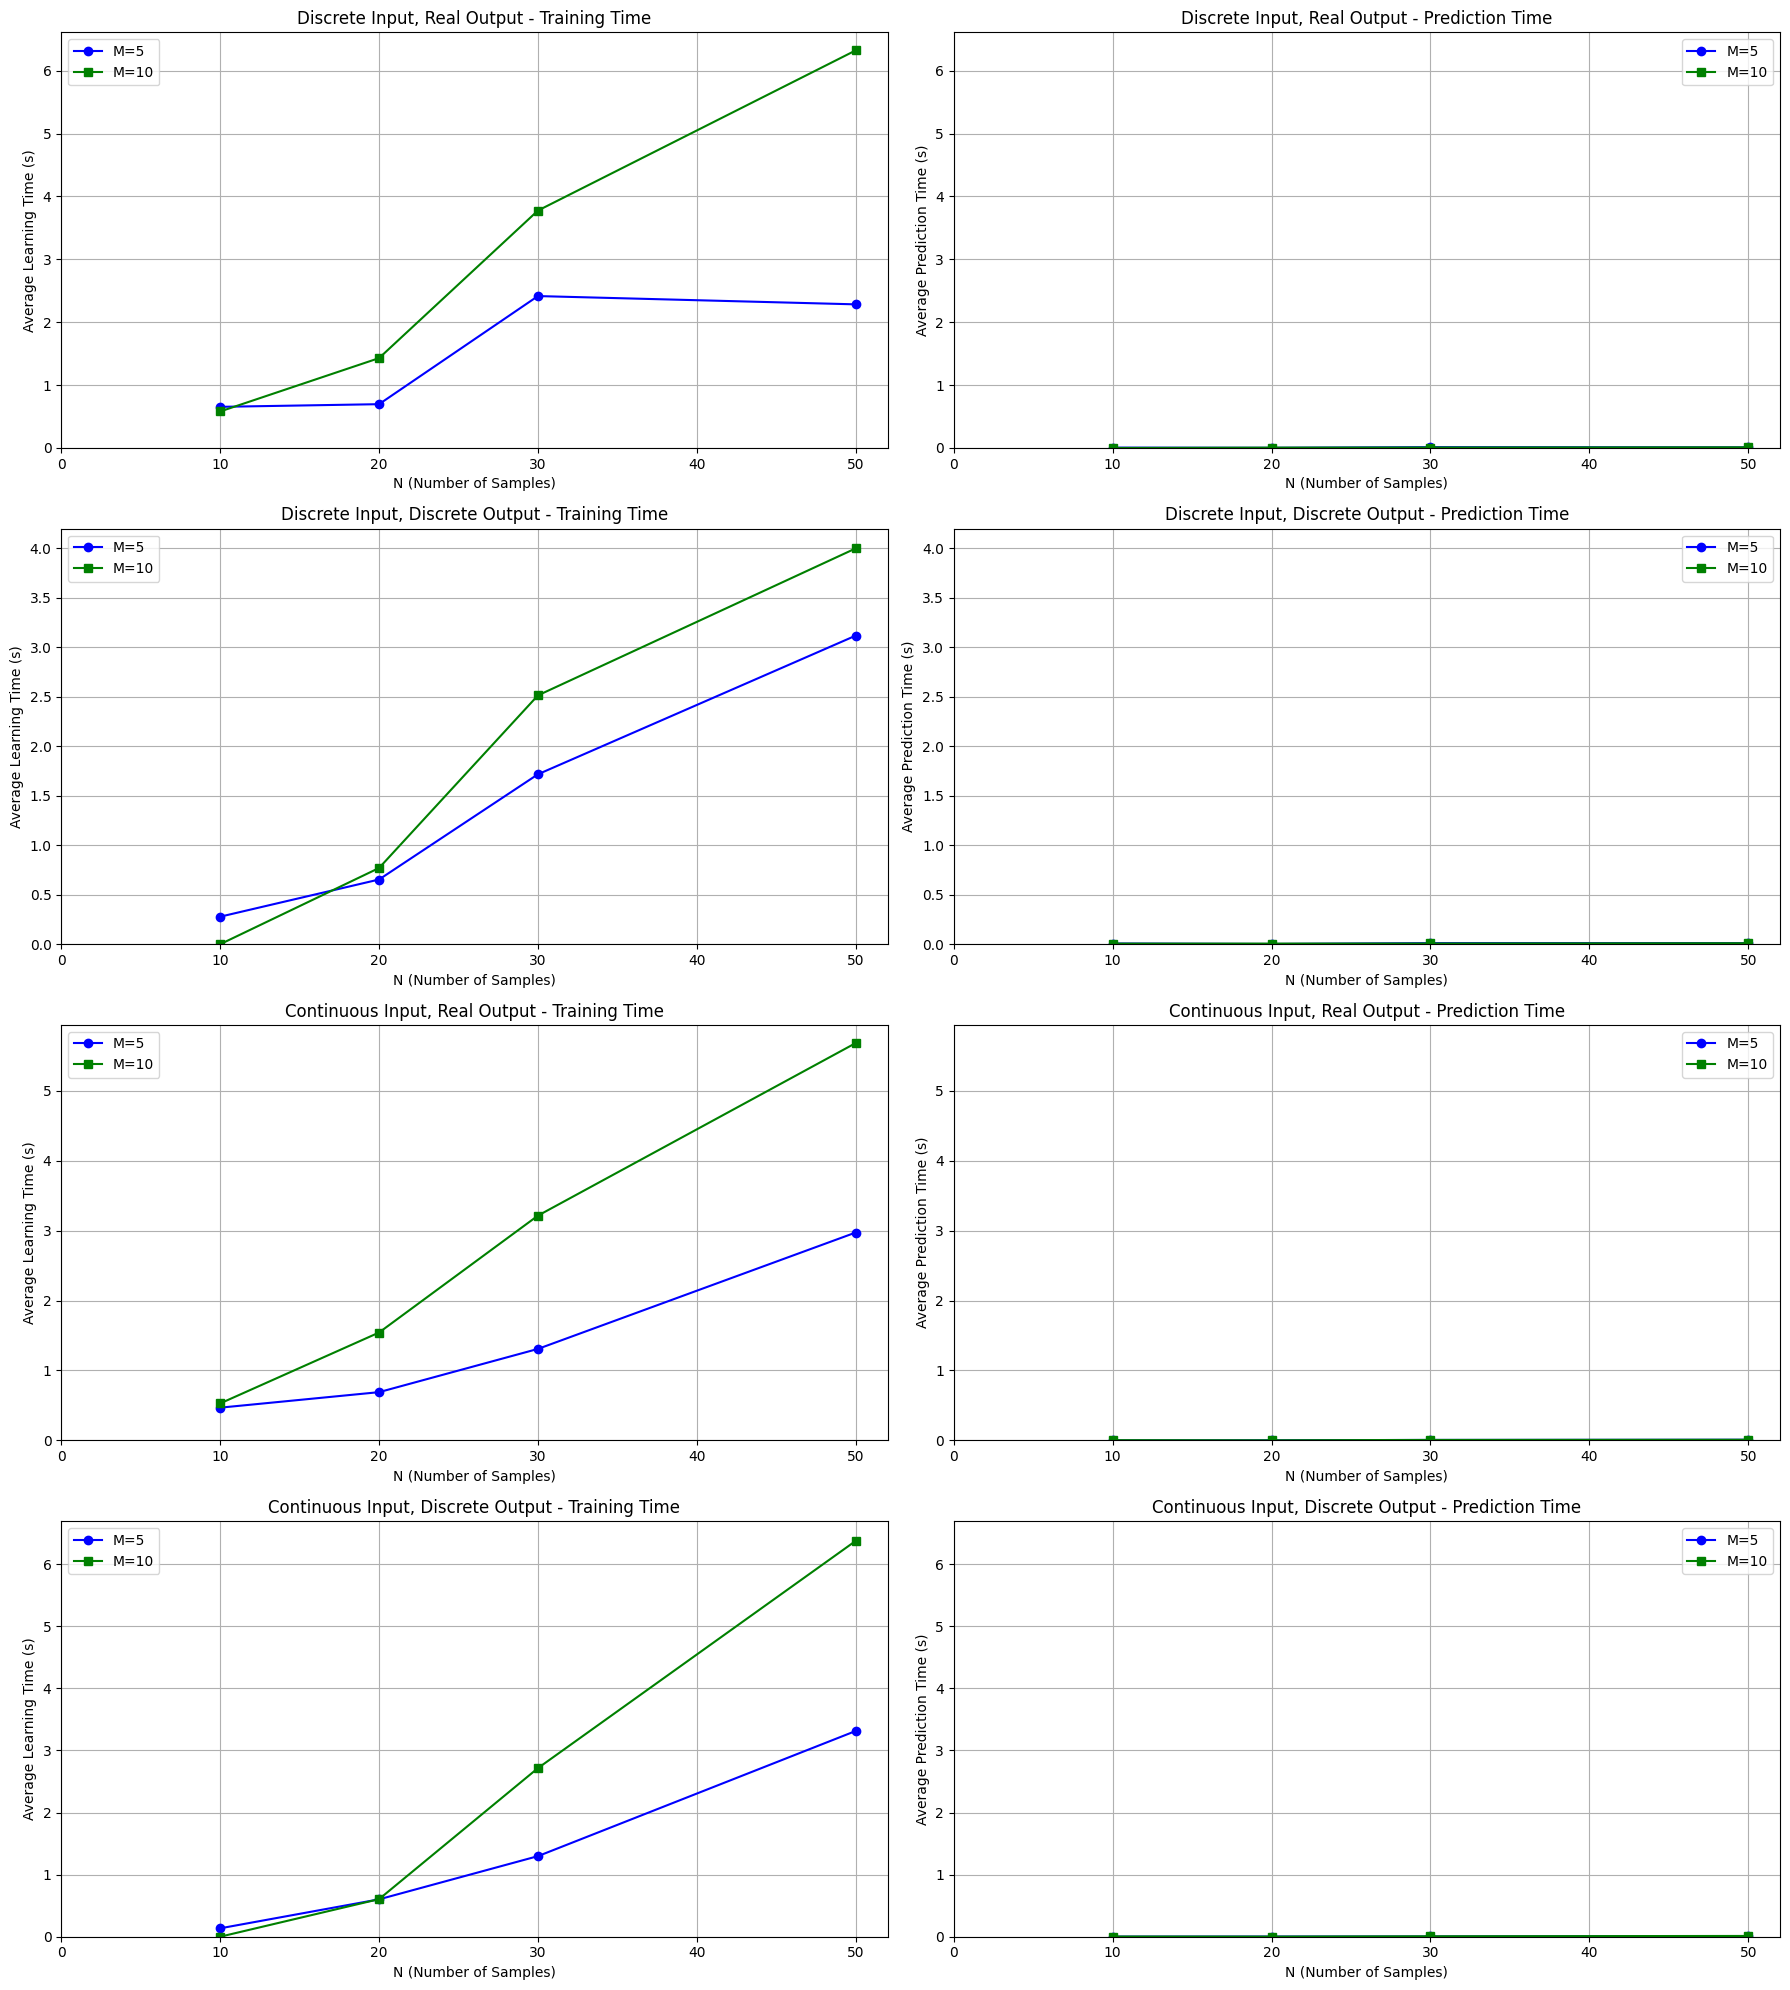

In [5]:
import matplotlib.pyplot as plt

# Function to plot the results side by side
fig, axs = plt.subplots(4, 2, figsize=(18, 20))

# Define markers and colors for different M values
markers = {5: 'o', 10: 's'}  # Marker for M=5 and M=10
colors = {5: 'blue', 10: 'green'}  # Colors for M=5 and M=10

# Mapping for subplot titles
titles = {
    (True, True): 'Discrete Input, Real Output',
    (True, False): 'Discrete Input, Discrete Output',
    (False, True): 'Continuous Input, Real Output',
    (False, False): 'Continuous Input, Discrete Output'
}

# Iterate over the four combinations of discrete/continuous input and real/discrete output
for i, (discrete_input, real_output) in enumerate([(True, True), (True, False), (False, True), (False, False)]):
    # Plot Learning Time
    ax_train = axs[i, 0]
    for M in [5, 10]:
        subset = results_df[(results_df['Discrete Input'] == discrete_input) & 
                            (results_df['Real Output'] == real_output) & 
                            (results_df['M'] == M)]
        ax_train.plot(subset['N'], subset['Learning Time Avg'], marker=markers[M], color=colors[M], label=f'M={M}')
    
    ax_train.set_title(f'{titles[(discrete_input, real_output)]} - Training Time')
    ax_train.set_xlabel('N (Number of Samples)')
    ax_train.set_ylabel('Average Learning Time (s)')
    ax_train.legend()
    ax_train.grid(True)
    
    # Plot Prediction Time
    ax_pred = axs[i, 1]
    for M in [5, 10]:
        subset = results_df[(results_df['Discrete Input'] == discrete_input) & 
                            (results_df['Real Output'] == real_output) & 
                            (results_df['M'] == M)]
        ax_pred.plot(subset['N'], subset['Prediction Time Avg'], marker=markers[M], color=colors[M], label=f'M={M}')
    
    ax_pred.set_title(f'{titles[(discrete_input, real_output)]} - Prediction Time')
    ax_pred.set_xlabel('N (Number of Samples)')
    ax_pred.set_ylabel('Average Prediction Time (s)')
    ax_pred.legend()
    ax_pred.grid(True)

    # Ensure that the axes are the same for both training and prediction plots
    ax_train.set_ylim([0, max(ax_train.get_ylim()[1], ax_pred.get_ylim()[1])])
    ax_pred.set_ylim([0, max(ax_train.get_ylim()[1], ax_pred.get_ylim()[1])])
    ax_train.set_xlim([0, max(ax_train.get_xlim()[1], ax_pred.get_xlim()[1])])
    ax_pred.set_xlim([0, max(ax_train.get_xlim()[1], ax_pred.get_xlim()[1])])

plt.tight_layout()
plt.show()


# Interpretation of the Plots

## Average Learning Time

The plots reveal that the **Average Learning Time** of the decision tree algorithm is influenced by both the number of samples (N) and the number of binary features (M). However, the variation in learning time is more significant with respect to the number of samples (N) than with the number of features (M). This observation aligns with the theoretical time complexity of training a decision tree, which is O(N.M.2^d). 

- The 2^d comes due to the number of nodes in the decision tree.
- The M comes as we try each feature for the best split for each node.
- The N comes as we try to sort the N rows and get the best split out of available options.

## Prediction Time

The **Prediction Time** remains almost constant and is relatively low compared to the learning time. This is consistent with the theoretical time complexity for prediction, which is O(M.d). During prediction:
- Each sample traverses a single path from the root to a leaf node, which involves \( d \) comparisons.
- Each comparison involves evaluating \( M \) features.

Thus, the prediction time is not significantly affected by changes in the number of samples but is dependent on the number of features.